# Pollution



Pour travailler sur les polluants, nous sommes partis sur les Données « temps réel » de mesure des concentrations de polluants atmosphériques réglementés du Laboratoire Central de Surveillance de la Qualité de l'Air (LCSQA) archivée sur [data.gouv.fr](https://www.data.gouv.fr/datasets/donnees-temps-reel-de-mesure-des-concentrations-de-polluants-atmospheriques-reglementes-1/informations) sous l'identifiant **5b98b648634f415309d52a50**. 

Les données de mesure de 2021 à 2025 sont archivées suivant un format CSV horaire.
Pour les données horaires de 2019 à 2021, elles sont archivées suivant un format XML.
Nous allons donc construire une aggrégation suivant l'indice réducteur ATMO par trimestre.
Dans la suite après la construction des données géographiques et de l'indice ATMO, nous aborderons la récupération dans un premier temps des données CSV puis de celles XML.


In [1]:
!pip install lxml

In [2]:
import json
import pandas as pd
import re
import os
import pathlib
import xml.etree.ElementTree as ET
import plotly.express as px
import unicodedata 

## Prerequis
Récupération des données en locale pour travailler.

Pour les données brutes, il faut télécharger le fichier :
https://oasis-prd-001.s3.us-east-1.amazonaws.com/raw/airquality/pollution-2021-2025-CSV.zip
et le décompresser dans le repertoire local _data_ à la racine du projet.

### Positionnement du repertoire de travail du départ du notebook

Adpatation pour se placer dans le repertoire : notebooks/pollution


In [3]:

%pwd
#os.chdir("../notebooks/pollution")
%pwd


'/Volumes/WSBLA1TO/Formation/Jedha/Jedha-dsfs-ft-35/Projets/Oasis/Repo/oasis/notebooks/pollution'

### Construction des repertoires de travail

In [4]:
pollution_notebook_dir=str(pathlib.Path().resolve())
print("pollution notebook directory :",pollution_notebook_dir)
os.chdir("../../data")
data_dir=str(pathlib.Path().resolve())
data_pollution_dir=data_dir+"/pollution"
print("data directory :",data_dir)
print("pollution data directory :",data_pollution_dir)
os.chdir("..")
repo_dir=str(pathlib.Path().resolve())
print("Oasis repository root directory :",repo_dir)
os.chdir("./notebooks/pollution")
print("Here we are :",pathlib.Path().resolve())

pollution notebook directory : /Volumes/WSBLA1TO/Formation/Jedha/Jedha-dsfs-ft-35/Projets/Oasis/Repo/oasis/notebooks/pollution
data directory : /Volumes/WSBLA1TO/Formation/Jedha/Jedha-dsfs-ft-35/Projets/Oasis/Repo/oasis/data
pollution data directory : /Volumes/WSBLA1TO/Formation/Jedha/Jedha-dsfs-ft-35/Projets/Oasis/Repo/oasis/data/pollution
Oasis repository root directory : /Volumes/WSBLA1TO/Formation/Jedha/Jedha-dsfs-ft-35/Projets/Oasis/Repo/oasis
Here we are : /Volumes/WSBLA1TO/Formation/Jedha/Jedha-dsfs-ft-35/Projets/Oasis/Repo/oasis/notebooks/pollution


## Acces au Bucket S3 Oasis
Il s'agit de l'ajout du code d'accès au bucket S3 :
https://oasis-prd-001.s3.us-east-1.amazonaws.com/data

In [5]:
import os

import boto3
import pandas as pd
from dotenv import load_dotenv


In [6]:
# Load environment variables
load_dotenv()

AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")


In [7]:
def load_file_s3(object_key: str)->pd.DataFrame:
    """Load a file from S3 and print its contents."""
    if not AWS_S3_BUCKET or not AWS_ACCESS_KEY_ID or not AWS_SECRET_ACCESS_KEY:
        raise ValueError("AWS credentials or bucket name not set in environment variables.")

    s3_client = boto3.client(
        "s3",
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    )

    response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=object_key)

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 get_object response. Status - {status}")
        return pd.read_csv(response.get("Body"))
    raise ValueError(f"Unsuccessful S3 get_object response. Status - {status}")


In [8]:
os.chdir(pollution_notebook_dir)

## Qu'est-ce qu'une Zone Administrative de Surveillance ?

Afin de répondre aux exigences européennes, la France est découpée en zones administratives de surveillance (ZAS). Ce zonage est indispensable pour les besoins de rapportage des données de mesure des polluants réglementés, auprès de la Commission européenne. Ces zones sont délimitées en tenant compte des niveaux de polluants et donc des risques de dépassements réglementaires, ainsi que des populations résidentes.

Depuis 2022, un nouveau zonage est mis en place pour 5 ans. Les zones administratives de surveillance sont classées en trois catégories ([lire l'Arrêté du 9 mars 2022](https://www.lcsqa.org/system/files/media/documents/JO-Arrete%2009%20mars%202022-découpage_regions-ZAS_0.pdf)) :

- « **zone à risques - agglomération** » (ZAG) qui comporte une agglomération de plus de 250 000 habitants, telle que définie par l’arrêté prévu à l’article L. 222-4 du code de l’environnement, ou ayant une densité d’habitants au kilomètre carré supérieure à un seuil établi par le ministère chargé de l’environnement
- « **zone à risques – hors agglomération** » (ZAR) qui ne répond pas aux critères des ZAG et dans lesquelles les normes de qualité de l’air mentionnées à l’article R. 221-1 du code de l’environnement ne sont pas respectées ou risquent de ne pas l’être
- « **zone régionale** » (ZR) qui s’étend sur le reste du territoire de la région
Les AASQA assurent la surveillance et l’évaluation de la qualité de l’air pour les polluants réglementés dans chaque Zone Administrative de Surveillance.

Plus d'information [ici](https://www.lcsqa.org/fr/les-zones-administratives-et-stations-de-surveillance) 

Le dispositif national de surveillance s’appuie sur des appareils de mesure conformes répartis sur près de 650 stations de mesures ainsi que sur des outils de modélisation.



### travail sur la localisation des stations et ZAS

 A partir de [l'arrêté du 9 mars 2022](), il a été possible d'extraire de l'annexe l'association entre les ZAS et les communes asociées.Cette association est placée dans le fichier JSON _zas_communes.json_ déposé dans le repertoire data et sur le bucket S3.

In [9]:
df_zar_ville=pd.read_csv(data_pollution_dir+"/zar_communes_groupes.csv")
df_zas_final=pd.read_csv(data_pollution_dir+"/communes_final_zr_zar_propre.csv")
commune_zar_villes=df_zar_ville[["zas","nom_commune_complet"]]
communes_zas_zr=df_zas_final[["zas","nom_commune_complet"]]
communes_zas=pd.concat([communes_zas_zr,commune_zar_villes])
dico=communes_zas.to_dict(orient="dict") #str {‘dict’, ‘list’, ‘series’, ‘split’, ‘tight’, ‘records’, ‘index’}
df1 = communes_zas.groupby('zas')['nom_commune_complet'].apply(list).reset_index(name='new')
df1=df1.set_index('zas')

dico_zas=df1.to_dict(orient="dict")['new']
#dico_zas['ZAR MOULINS']

Lecture d'un fichier csv pour obtenir la liste des ZAS

In [10]:
zas_reverse=data_pollution_dir+"/pollution-2020-2025-CSV/2025/"+"FR_E2_2025-01-01.csv"
df=pd.read_csv(zas_reverse,delimiter=";")
df.info()
kept_columns=["code site","Zas","nom site","type d'implantation"]
df_zas=df[kept_columns].drop_duplicates()
df_zas.set_index("code site",inplace=True)
df_zas.info()
df_zas.at['FR01018','Zas']
dicozas=df_zas.to_dict(orient='dict')['Zas']

df_zas['Zas'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49992 entries, 0 to 49991
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date de début          49992 non-null  object 
 1   Date de fin            49992 non-null  object 
 2   Organisme              49992 non-null  object 
 3   code zas               49992 non-null  object 
 4   Zas                    49992 non-null  object 
 5   code site              49992 non-null  object 
 6   nom site               49992 non-null  object 
 7   type d'implantation    49992 non-null  object 
 8   Polluant               49992 non-null  object 
 9   type d'influence       49992 non-null  object 
 10  discriminant           43296 non-null  object 
 11  Réglementaire          49992 non-null  object 
 12  type d'évaluation      49992 non-null  object 
 13  procédure de mesure    49992 non-null  object 
 14  type de valeur         49992 non-null  object 
 15  va

array(['ZAG METZ', 'ZR GRAND-EST', 'ZAG MARSEILLE-AIX',
       'ZR PROVENCE-ALPES-COTE-D-AZUR', 'ZAG TOULON', 'ZAG AVIGNON',
       'ZAG PARIS', 'ZR ILE-DE-FRANCE', 'ZAR LE-HAVRE', 'ZR NORMANDIE',
       'ZAG BLDV', 'ZR HAUTS-DE-FRANCE', 'ZAG CLERMONT-FERRAND',
       'ZR AUVERGNE-RHONE-ALPES', 'ZAG MONTPELLIER', 'ZR OCCITANIE',
       'ZAR NIMES', 'ZAR PERPIGNAN', 'ZR NOUVELLE-AQUITAINE',
       'ZAR COTE-D-OPALE', 'ZAG LILLE', 'ZAG TOULOUSE', 'ZAR REIMS',
       'ZAG GRENOBLE', 'ZAG STRASBOURG', 'ZAR AMIENS', 'ZAR CREIL',
       'ZAG RENNES', 'ZAR BREST', 'ZR BRETAGNE', 'ZAG LYON', 'ZAR CAEN',
       'ZAG NANTES-SAINT-NAZAIRE', 'ZR PAYS-DE-LA-LOIRE',
       'ZAR ANGERS-LOIRE', 'ZAR LAVAL', 'ZAR LE-MANS', 'ZAG NICE',
       'ZAG ROUEN', 'ZAR DIJON', 'ZR BOURGOGNE-FRANCHE-COMTE',
       'ZAR VALLEE-DU-RHONE', 'ZAR ARRAS', 'ZAG SAINT-ETIENNE',
       'ZAG NANCY', 'ZAG BORDEAUX', 'ZAG BAYONNE', 'ZAR CHALON',
       'ZAR PAYS-DE-SAVOIE', 'ZAR VALLEE-DE-L-ARVE',
       'ZAR VALLEE-DE-LA-TA

In [11]:
zas=dico_zas
def Zas_Commune_INSEE_List(zas_str:str)->list:
    try:
        zas[zas_str]
    except: 
        print(" ZAS inconnue : ",zas_str)
        return ["UNKNOWN ZAS",]
    return zas[zas_str]

In [12]:
# test de la focntion d'association des communes au code INSEE
#display(zas)
display(Zas_Commune_INSEE_List('ZAR REIMS'))
display(Zas_Commune_INSEE_List('ZAR CHARTRES-DREUX'))
display(Zas_Commune_INSEE_List('ZR AUVERGNE-RHONE-ALPES'))
display(Zas_Commune_INSEE_List('ZAR MOULINS'))


['Bezannes',
 'Bétheny',
 'Cernay-lès-Reims',
 'Champfleury',
 'Champigny',
 'Cormontreuil',
 'Prunay',
 'Puisieulx',
 'Reims',
 'Saint-Brice-Courcelles',
 'Sillery',
 'Taissy',
 'Tinqueux',
 'Trois-Puits',
 'Villers-aux-Nœuds']

['Chartres', 'Dreux', 'Lucé', 'Nogent-le-Rotrou']

['Balan',
 'Baneins',
 'Beaupont',
 'Beauregard',
 'Bellignat',
 'Béligneux',
 'Bellegarde-sur-Valserine',
 'Belley',
 'Belleydoux',
 'Belmont-Luthézieu',
 'Bénonces',
 'Bény',
 'Béon',
 'Béréziat',
 'Bettant',
 'Bey',
 'Beynost',
 'Billiat',
 'Birieux']

['Moulins',
 'Avermes',
 'Bessay-sur-Allier',
 'Moulins',
 'Toulon-sur-Allier',
 'Trévol',
 'Villeneuve-sur-Allier',
 'Yzeure',
 'Moulins']

Nous récupérons notre référentiel INSEE des communes de France métropolitaine. Cela va nous permettre de construire un "mapping" entre les communes et leur ZAS associée.

In [13]:

def enlever_accents_majuscules(texte:str)->str:
    texte_modifie = ''
    for c in texte:
        # Si le caractère est une majuscule accentuée
        if c.isupper():
            # Normalisation et retrait des diacritiques uniquement pour les majuscules
            c_sans_accent = unicodedata.normalize('NFD', c)
            c_sans_accent = ''.join(ch for ch in c_sans_accent if unicodedata.category(ch) != 'Mn')
            texte_modifie += c_sans_accent
        else:
            texte_modifie += c  # laisse tel quel
    return texte_modifie

# test de la fonction de retrait d'accent sur les majuscules 
print(enlever_accents_majuscules("Éragny à toute")," doit devenir Eragny à toute")

Eragny à toute  doit devenir Eragny à toute


In [14]:
df_insee=pd.read_csv(data_dir+"/ref_espace_communes.csv")
df_insee.info()
display(df_insee.describe(include='all'))
df_insee.head()

df_insee["nom_commune_SANS_ACCENT"]= df_insee["nom_commune_complet"].apply(enlever_accents_majuscules)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38725 entries, 0 to 38724
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_commune_INSEE   38725 non-null  object 
 1   code_postal          38725 non-null  int64  
 2   latitude             38723 non-null  float64
 3   longitude            38723 non-null  float64
 4   nom_commune_complet  38725 non-null  object 
 5   nom_departement      38725 non-null  object 
 6   code_region          38725 non-null  int64  
 7   nom_region           38725 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.4+ MB


,code_commune_INSEE,code_postal,latitude,longitude,nom_commune_complet,nom_departement,code_region,nom_region
count,38725,38725.000000,38723.000000,38723.000000,38725,38725,38725.000000,38725
unique,35794,NaN,NaN,NaN,33415,96,NaN,13
top,14371,NaN,NaN,NaN,Livarot-Pays-d'Auge,Pas-de-Calais,NaN,Grand Est
freq,22,NaN,NaN,NaN,22,915,NaN,5673
mean,NaN,46176.633002,46.972847,2.777677,NaN,NaN,52.380323,NaN
std,NaN,25424.890978,2.208447,2.688828,NaN,NaN,24.193330,NaN
min,NaN,1000.000000,41.435499,-5.085345,NaN,NaN,11.000000,NaN
25%,NaN,24530.000000,45.177116,0.678146,NaN,NaN,28.000000,NaN
50%,NaN,48400.000000,47.399587,2.686538,NaN,NaN,44.000000,NaN
75%,NaN,66820.000000,48.828772,4.963445,NaN,NaN,76.000000,NaN


In [15]:
topzas={}
for key,val in zas.items():
    print(f"zas : {key}")
    for commune in val:
        #indices = df_insee.where(df_insee['nom_commune_complet']==commune)
        index = df_insee.isin([commune]).any(axis=1).idxmax()
        region=df_insee.loc[index,"code_region"]
        dico={"commune": commune, "zas": key, "code_region": region}
        topzas[df_insee.loc[index,"code_commune_INSEE"]]=dico
        print(topzas[df_insee.loc[index,"code_commune_INSEE"]])
        #insee=df_insee[df_insee['nom_commune_complet']==commune].iloc[0,0]
        #print(f"commune : {commune} code INSEE: {insee}")

zas : ZAG AVIGNON
{'commune': 'Thor (Le)', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(84)}
{'commune': 'Althen-des-Paluds', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Aubignan', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Avignon', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Barbentane', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Beaumes-de-Venise', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Beaumettes', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Bollène', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Bédarrides', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Cabannes', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': "Cabrières-d'Avignon", 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Caderousse', 'zas': 'ZAG AVIGNON', 'code_region': np.int64(93)}
{'commune': 'Caromb', 'zas': 'ZAG AVIGNON', 'c

In [16]:
df_zas=pd.DataFrame(topzas).T
df_zas.index.rename("INSEECOM",inplace=True)
#display(df_zas.describe())
df_zas.to_csv(data_pollution_dir+"/INSEE_COM_ZAS.csv")

## Les données sur les polluants

Les données disponibles par ces processus permettent de documenter les concentrations des
polluants atmosphériques suivants :
- Ozone (O3)
- Dioxyde d’azote (NO2)
- Dioxyde de soufre (SO2)
- Particules de diamètre inférieur à 10 micron (PM10)
- Particules de diamètre inférieur à 2,5 micron (PM2.5)
- Monoxyde de carbone (CO)
L’ensemble des observations mesurées pour les polluants ci-dessus qui participent au
dispositif de surveillance réglementaire sont mises à disposition. Les stations dont elles sont
issues ne disposent pas toutes de mesures pour l’ensemble de ces polluants, certaines ne
mesurent qu’un seul polluant de la liste, d’autres en mesurent plus.



In [17]:
# La liste des polluants de l’Air Quality Directive (AQD) est disponible dans la vocabulaire aq/pollutant
#  du Data Dictionary Eionet. 
# Chaque polluant est référencé par une URI du type :
#               http://dd.eionet.europa.eu/vocabulary/aq/pollutant/<numéro>
# la table des polluants a été constituée à partir du scraping du site dd.eionet.europa.eu
#
df=pd.read_csv(data_pollution_dir+'/pollutants_table.csv')
polluant_dico={}
for index, row in df.iterrows():
    d=row.to_dict()
    print(d)
    polluant_dico[d['Id']]=d

print("")

print( list(df['Notation']) )
polluant_dico


{'Id': 1, 'Label': 'Sulphur dioxide (air)', 'Definition': 'SO2 - recommended unit: µg/m3', 'Status': 'Valid', 'Status Modified': '20.09.2013', 'Notation': 'SO2'}
{'Id': 3, 'Label': 'Strong acidity (air)', 'Definition': 'SA - recommended unit: µg SO2/m3', 'Status': 'Valid', 'Status Modified': '20.09.2013', 'Notation': 'SA'}
{'Id': 4, 'Label': 'Total suspended particulates (aerosol)', 'Definition': 'SPM - recommended unit: µg/m3', 'Status': 'Valid', 'Status Modified': '20.09.2013', 'Notation': 'SPM'}
{'Id': 5, 'Label': 'Particulate matter < 10 µm (aerosol)', 'Definition': 'PM10 - recommended unit: µg/m3', 'Status': 'Valid', 'Status Modified': '20.09.2013', 'Notation': 'PM10'}
{'Id': 6, 'Label': 'Black smoke (air)', 'Definition': 'BS - recommended unit: µg/m3', 'Status': 'Valid', 'Status Modified': '20.09.2013', 'Notation': 'BS'}
{'Id': 7, 'Label': 'Ozone (air)', 'Definition': 'O3 - recommended unit: µg/m3', 'Status': 'Valid', 'Status Modified': '20.09.2013', 'Notation': 'O3'}
{'Id': 8, '

{1: {'Id': 1,
  'Label': 'Sulphur dioxide (air)',
  'Definition': 'SO2 - recommended unit: µg/m3',
  'Status': 'Valid',
  'Status Modified': '20.09.2013',
  'Notation': 'SO2'},
 3: {'Id': 3,
  'Label': 'Strong acidity (air)',
  'Definition': 'SA - recommended unit: µg SO2/m3',
  'Status': 'Valid',
  'Status Modified': '20.09.2013',
  'Notation': 'SA'},
 4: {'Id': 4,
  'Label': 'Total suspended particulates (aerosol)',
  'Definition': 'SPM - recommended unit: µg/m3',
  'Status': 'Valid',
  'Status Modified': '20.09.2013',
  'Notation': 'SPM'},
 5: {'Id': 5,
  'Label': 'Particulate matter < 10 µm (aerosol)',
  'Definition': 'PM10 - recommended unit: µg/m3',
  'Status': 'Valid',
  'Status Modified': '20.09.2013',
  'Notation': 'PM10'},
 6: {'Id': 6,
  'Label': 'Black smoke (air)',
  'Definition': 'BS - recommended unit: µg/m3',
  'Status': 'Valid',
  'Status Modified': '20.09.2013',
  'Notation': 'BS'},
 7: {'Id': 7,
  'Label': 'Ozone (air)',
  'Definition': 'O3 - recommended unit: µg/m3'

### Description des polluants retenus et leur type de mesure
Pour décrire la pollution, nous nous appuyons sur l'indice ATMO car son calcul est obligatoire sur l'ensemble du territoire français.

Cinq polluants sont utilisés pour construire cet indice :
- Les particules fines < 2.5 microns (PM2.5)
- Les particules fines < 10 microns (PM10)
- L’ozone (O3)
- Le dioxyde d’azote (NO2)
- Le dioxyde de soufre (SO2) 

L’indice ATMO est un indicateur journalier qualificatif de la qualité de l’air. Il se décline en six qualificatifs définis selon différentes classes pour ces cinq polluants : « bon », « moyen », « dégradé », « mauvais », « très mauvais », « extrêmement mauvais ». 

Il intègre les polluants réglementés que l’on rencontre au quotidien : les particules en suspension (PM10 et PM2.5), le dioxyde d’azote (NO2), l’ozone (O3) et le dioxyde de soufre (SO2).

Pour plus d'information, le lecteur interessé peut se reporter au [ guide de Fédération des Associations agréées de surveillance de la qualité de l'air](https://github.com/nclsprsnw/oasis/blob/3234b05d564177b08e92d209071888ba76529ffb/docs/guide_calcul_nouvel_indice_fedeAtmo_14122020.pdf)


Le code Python suivant sert à appréhender les données des fichiers journaliers des mesures de polluant.

In [18]:

df_pollu_test=pd.read_csv(data_pollution_dir+"/pollution-2020-2025-CSV/2025/FR_E2_2025-01-01.csv",delimiter=";")
print("Polluant")
print(df_pollu_test["Polluant"].unique())
print("ZAS")
print(df_pollu_test["Zas"].unique())
print(df_pollu_test.info())
print(df_pollu_test.head(20))
df_pollu_test["Date"]=pd.to_datetime(df_pollu_test["Date de début"], format = "%Y/%m/%d %H:%M:%S")#2021/01/01 02:00:00
df_pollu_test["Year"]=df_pollu_test["Date"].dt.year
#df_tmp0=df_pollu_test[df_pollu_test["Polluant"]=="PM2.5"][["code site","valeur"]].groupby("code site").mean()
df_tmp0=df_pollu_test[df_pollu_test["Polluant"].isin(values=("PM2.5","PM10"))][["Date","Zas","code site","Polluant","valeur"]].groupby(["Date","Zas","code site","Polluant"]).mean()
#df_tmp0[["code site","valeur"]].groupby("code site").mean()
#df_tmp=df_pollu_test[df_pollu_test["Polluant"]=="PM2.5"].groupby("code site").mean()
print(df_tmp0)
df_tmp1=df_pollu_test[df_pollu_test["Polluant"].isin(values=("NO2","SO2","O3"))][["Date","Zas","code site","Polluant","valeur"]].groupby(["Date","Zas","code site","Polluant"]).max()
print(df_tmp1)
df_tmpf=pd.concat([df_tmp0,df_tmp1]).reset_index()
print(df_tmpf.info())
print(df_tmpf.tail(20))
print(df_tmpf.index.names)
df_tmpf['valeur']=df_tmpf['valeur'].fillna(0)
#print(df_tmpf[(df_tmpf["Date"]=="01/01/2025") & (df_tmpf["code site"]=="FR01011")])
display(df_pollu_test)

Polluant
['NO' 'NO2' 'O3' 'NOX as NO2' 'PM10' 'PM2.5' 'C6H6' 'SO2' 'CO']
ZAS
['ZAG METZ' 'ZR GRAND-EST' 'ZAG MARSEILLE-AIX'
 'ZR PROVENCE-ALPES-COTE-D-AZUR' 'ZAG TOULON' 'ZAG AVIGNON' 'ZAG PARIS'
 'ZR ILE-DE-FRANCE' 'ZAR LE-HAVRE' 'ZR NORMANDIE' 'ZAG BLDV'
 'ZR HAUTS-DE-FRANCE' 'ZAG CLERMONT-FERRAND' 'ZR AUVERGNE-RHONE-ALPES'
 'ZAG MONTPELLIER' 'ZR OCCITANIE' 'ZAR NIMES' 'ZAR PERPIGNAN'
 'ZR NOUVELLE-AQUITAINE' 'ZAR COTE-D-OPALE' 'ZAG LILLE' 'ZAG TOULOUSE'
 'ZAR REIMS' 'ZAG GRENOBLE' 'ZAG STRASBOURG' 'ZAR AMIENS' 'ZAR CREIL'
 'ZAG RENNES' 'ZAR BREST' 'ZR BRETAGNE' 'ZAG LYON' 'ZAR CAEN'
 'ZAG NANTES-SAINT-NAZAIRE' 'ZR PAYS-DE-LA-LOIRE' 'ZAR ANGERS-LOIRE'
 'ZAR LAVAL' 'ZAR LE-MANS' 'ZAG NICE' 'ZAG ROUEN' 'ZAR DIJON'
 'ZR BOURGOGNE-FRANCHE-COMTE' 'ZAR VALLEE-DU-RHONE' 'ZAR ARRAS'
 'ZAG SAINT-ETIENNE' 'ZAG NANCY' 'ZAG BORDEAUX' 'ZAG BAYONNE' 'ZAR CHALON'
 'ZAR PAYS-DE-SAVOIE' 'ZAR VALLEE-DE-L-ARVE' 'ZAR VALLEE-DE-LA-TARANTAISE'
 'ZAG ORLEANS' 'ZAG TOURS' 'ZR CENTRE-VAL-DE-LOIRE' 'ZAR BLOIS

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,...,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité,Date,Year
0,2025/01/01 00:00:00,2025/01/01 01:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO,Fond,...,0.7,0.650,µg-m3,NaN,NaN,NaN,A,1,2025-01-01 00:00:00,2025
1,2025/01/01 01:00:00,2025/01/01 02:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO,Fond,...,0.7,0.675,µg-m3,NaN,NaN,NaN,A,1,2025-01-01 01:00:00,2025
2,2025/01/01 02:00:00,2025/01/01 03:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO,Fond,...,0.4,0.350,µg-m3,NaN,NaN,NaN,A,1,2025-01-01 02:00:00,2025
3,2025/01/01 03:00:00,2025/01/01 04:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO,Fond,...,0.6,0.575,µg-m3,NaN,NaN,NaN,A,1,2025-01-01 03:00:00,2025
4,2025/01/01 04:00:00,2025/01/01 05:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO,Fond,...,0.3,0.275,µg-m3,NaN,NaN,NaN,A,1,2025-01-01 04:00:00,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49987,2025/01/01 19:00:00,2025/01/01 20:00:00,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZRE01,ZR BOURGOGNE-FRANCHE-COMTE,FR82070,Baume-les-Dames,Urbaine,PM2.5,Trafic,...,64.1,64.075,µg-m3,NaN,NaN,NaN,A,1,2025-01-01 19:00:00,2025
49988,2025/01/01 20:00:00,2025/01/01 21:00:00,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZRE01,ZR BOURGOGNE-FRANCHE-COMTE,FR82070,Baume-les-Dames,Urbaine,PM2.5,Trafic,...,63.4,63.400,µg-m3,NaN,NaN,NaN,A,1,2025-01-01 20:00:00,2025
49989,2025/01/01 21:00:00,2025/01/01 22:00:00,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZRE01,ZR BOURGOGNE-FRANCHE-COMTE,FR82070,Baume-les-Dames,Urbaine,PM2.5,Trafic,...,73.4,73.375,µg-m3,NaN,NaN,NaN,A,1,2025-01-01 21:00:00,2025
49990,2025/01/01 22:00:00,2025/01/01 23:00:00,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZRE01,ZR BOURGOGNE-FRANCHE-COMTE,FR82070,Baume-les-Dames,Urbaine,PM2.5,Trafic,...,76.1,76.100,µg-m3,NaN,NaN,NaN,A,1,2025-01-01 22:00:00,2025


### Definition de l'indice ATMO.

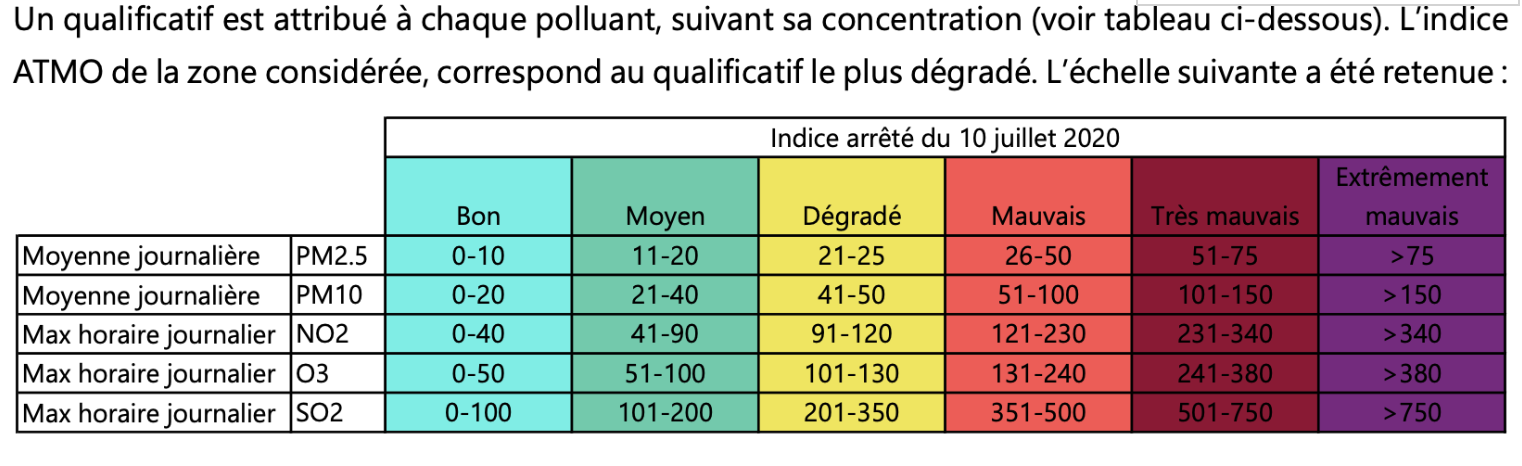

La variable ```polluants``` correspond au seuil des qualificatifs et à la méthode de mesure de ces derniers. Il s'agit de la création d'un dictionnaire synthétisant les informations du tableau ci-dessous.



In [19]:
polluants={ "PM2.5":((10.0,20.0,25.0,50.0,75.0),
                     "Moyenne journalière"),
            "PM10":((20.0,40.0,50.0,100.0,150.0), 
                    "Moyenne journalière"),
            "NO2":((40.0,90.0,120.0,230.0,340.0),
                   "Max horaire journalier"),
            "O3":((50.0,100.0,130.0,240.0,380.0),
                  "Max horaire journalier"),
            "SO2":((100.0,200.0,350.0,500.0,750.0),
                   "Max horaire journalier")}

La fonction ci-dessous permet de traduire les valeurs des différents polluants en l'indice normalisé ATMO.

In [20]:
def Criterion_ATMO(no2:float,so2:float,o3:float, pm25:float, pm10:float)->int:
    resu=0
    for i, val in enumerate(polluants["NO2"][0]):
        #print("i ",i," val ",val,"  no2 ",no2," resu ",resu)
        if (no2>val): 
            resu=max(resu,i)   
    for i, val in enumerate(polluants["SO2"][0]):
        if so2>val: 
            resu=max(resu,i)
    for i, val in enumerate(polluants["O3"][0]):
        if o3>val: 
            resu=max(resu,i)
    for i, val in enumerate(polluants["PM2.5"][0]):
        if pm25>val: 
            resu=max(resu,i)
    for i, val in enumerate(polluants["PM10"][0]):
        if pm10>val: 
            resu=max(resu,i)
    return int(resu)

def Polluant_H2D(df:pd.DataFrame)-> pd.DataFrame:
    # regroupper par "code site", 
    # garder pour les "Polluant": [ 'NO2', 'O3', 'PM10', 'PM2.5',  'SO2']  sur ['NO', 'NO2', 'O3', 'NOX as NO2', 'PM10', 'PM2.5', 'C6H6', 'SO2', 'CO']
    df_tmp0=df[df["Polluant"].isin(values=("PM2.5","PM10"))][["Date","Year","Month","Quarter","Zas","code site","Polluant","valeur"]].groupby(["Date","Year","Month","Quarter","Zas","code site","Polluant"]).mean()
    df_tmp1=df[df["Polluant"].isin(values=("NO2","SO2","O3"))][["Date","Year","Month","Quarter","Zas","code site","Polluant","valeur"]].groupby(["Date","Year","Month","Quarter","Zas","code site","Polluant"]).max()
    df_tmpf=pd.concat([df_tmp0,df_tmp1]).reset_index()
    return df_tmpf

def Csv_Traitement(file) -> pd.DataFrame:
    #
    # we read a daily file, transform the date 
    # and compute for the whole day Polluant according to ATMO guide.
    # Unaccessary columns are removed :
    # ["Date de début", "Date de fin","Organisme","code zas","taux de saisie","couverture temporelle","couverture de données"]
    # 
    df=pd.read_csv(file,delimiter=";")
    df["Date"]=pd.to_datetime(df["Date de début"], format = "%Y/%m/%d %H:%M:%S")
    df["Year"]=df["Date"].dt.year
    df["Month"]=df["Date"].dt.month
    df["Quarter"]=df["Date"].dt.quarter
    #display(df.info())
    df=df.drop(columns=["Date de début", "Date de fin","Organisme","code zas","taux de saisie","couverture temporelle","couverture de données"])
    df=Polluant_H2D(df)
    #df1=df[df["Polluant"].isin(values=("PM2.5","PM10"))][["Date","Zas","code site","Polluant","valeur"]].groupby(["Date","Zas","code site","Polluant"]).mean()
    #df2=df[df["Polluant"].isin(values=("NO2","SO2","O3"))][["Date","Zas","code site","Polluant","valeur"]].groupby(["Date","Zas","code site","Polluant"]).max()
    #df=pd.concat([df1,df2]).reset_index()
    df['valeur']=df['valeur'].fillna(0.0)
    return df




In [23]:
def build_dayly_dataframe_ATMO(df_tmpf:pd.DataFrame)->pd.DataFrame:
    date=pd.to_datetime(df_tmpf["Date"])[0]
    year=0
    month=0
    quarter=0
    try:
     year=df_tmpf["Date"].dt.year[0]
     month=df_tmpf["Date"].dt.month[0]
     quarter=df_tmpf["Date"].dt.quarter[0]
    except:
        print("Pb Datetime dans build_dayly_dataframe_ATMO")
    #print(f"{year}/{month}-{quarter}")
    #print(df_tmpf["Zas"].unique())
    for zas in df_tmpf["Zas"].unique():
        stations=df_tmpf[df_tmpf["Zas"]==zas]["code site"].unique()
        #print(stations)
        for site in stations:
            df_int=df_tmpf[df_tmpf["code site"]==site]
            no2=0.0
            if (len(df_int[df_int["Polluant"]=="NO2"].valeur) >0) : 
                no2=df_int[df_int["Polluant"]=="NO2"].valeur.iloc[0]
            pm25=0.0
            if (len(df_int[df_int["Polluant"]=="PM2.5"].valeur) >0) : 
                pm25=df_int[df_int["Polluant"]=="PM2.5"].valeur.iloc[0]
            pm10=0.0
            if (len(df_int[df_int["Polluant"]=="PM10"].valeur) >0) : 
                pm10=df_int[df_int["Polluant"]=="PM10"].valeur.iloc[0]
            o3=0.0
            if (len(df_int[df_int["Polluant"]=="O3"].valeur) >0) : 
                o3=df_int[df_int["Polluant"]=="O3"].valeur.iloc[0]
            so2=0.0
            #print("len : ",len(df_int[df_int["Polluant"]=="SO2"].valeur))
            if (len(df_int[df_int["Polluant"]=="SO2"].valeur) >0) : 
                so2=df_int[df_int["Polluant"]=="SO2"].valeur.iloc[0]
            atmo=int(Criterion_ATMO(no2,so2,o3, pm25, pm10))
            #print(site," NO2 : ",no2," SO2 : ",so2," O3 : ", o3, " PM10 : ", pm10," PM2.5 : ",pm25, " ATMO : ",atmo)
            new_row=pd.Series({"Date": date ,"Year": year, "Month": month,"Quarter": quarter, "Zas": zas, "code site":site, "Polluant": "ATMO", "valeur": int(atmo) })
            #print(new_row.to_frame().T)
            df_tmpf=pd.concat([df_tmpf,new_row.to_frame().T],ignore_index=True)
            #print(atmo)
    df_tmpf=df_tmpf[df_tmpf["Polluant"]=="ATMO"]
    return df_tmpf
   

## Travail sur les fichiers CSV


In [22]:
print(polluants)
df_test=Csv_Traitement(data_pollution_dir+"/pollution-2020-2025-CSV/2021/FR_E2_2021-01-01.csv") 
df_test=build_dayly_dataframe_ATMO(df_test)

{'PM2.5': ((10.0, 20.0, 25.0, 50.0, 75.0), 'Moyenne journalière'), 'PM10': ((20.0, 40.0, 50.0, 100.0, 150.0), 'Moyenne journalière'), 'NO2': ((40.0, 90.0, 120.0, 230.0, 340.0), 'Max horaire journalier'), 'O3': ((50.0, 100.0, 130.0, 240.0, 380.0), 'Max horaire journalier'), 'SO2': ((100.0, 200.0, 350.0, 500.0, 750.0), 'Max horaire journalier')}


In [29]:
df_test.info()
df_test.isna().sum().sum()
df_test.describe(include='all')
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 543 entries, 32568 to 33110
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       543 non-null    object
 1   Year       543 non-null    object
 2   Month      543 non-null    object
 3   Quarter    543 non-null    object
 4   Zas        543 non-null    object
 5   code site  543 non-null    object
 6   Polluant   543 non-null    object
 7   valeur     543 non-null    object
dtypes: object(8)
memory usage: 38.2+ KB


/var/folders/6m/4bfx39_j0519_3g3r0sp6fbw0000gn/T/ipykernel_74190/1577671921.py:3: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df_test.describe(include='all')


,Date,Year,Month,Quarter,Zas,code site,Polluant,valeur
32568,2021-01-01 00:00:00,2021,1,1,ZAG AVIGNON,FR03080,ATMO,0
32569,2021-01-01 00:00:00,2021,1,1,ZAG AVIGNON,FR03087,ATMO,0
32570,2021-01-01 00:00:00,2021,1,1,ZAG AVIGNON,FR03084,ATMO,0
32571,2021-01-01 00:00:00,2021,1,1,ZAG AVIGNON,FR03088,ATMO,0
32572,2021-01-01 00:00:00,2021,1,1,ZAG BLDV,FR06001,ATMO,0


In [30]:
labels=("Date","Year","Month","Quarter","Zas","code site","ATMO")

In [31]:
df_out=pd.DataFrame(columns=labels)

In [29]:
#df_pollu=pd.read_csv("donnees-temps-reel-de-mesure-des-concentrations-de-polluants-atmospheriques-reglementes-1/temps-reel/2025/FR_E2_2025-01-01.csv",delimiter=";")

#os.chdir("./donnees-temps-reel-de-mesure-des-concentrations-de-polluants-atmospheriques-reglementes-1/temps-reel/2025")
files=[]

df_pollu=pd.DataFrame()
for annee in (2021,):#2022,2023,2024,2025):#2021,2022,2023,2024,2025 #'Test',
    print(annee)
    os.chdir(data_pollution_dir+"/pollution-2020-2025-CSV/"+str(annee))
    for file in os.listdir():
        print(file)
        df_temp=Csv_Traitement(file)
        df_temp= build_dayly_dataframe_ATMO(df_temp)
        df_pollu = pd.concat([df_pollu,df_temp], ignore_index=True)
    df_pollu.to_csv(data_pollution_dir+f"/pollution-day-{annee}.csv")
os.chdir(pollution_notebook_dir)
#df_pollu = pd.concat(map(Csv_Traitement, files), ignore_index=True)  
df_pollu.to_csv(data_pollution_dir+"/pollution-day.csv")       

2021
FR_E2_2021-01-01.csv
FR_E2_2021-01-02.csv
FR_E2_2021-01-03.csv
FR_E2_2021-01-04.csv
FR_E2_2021-01-05.csv
FR_E2_2021-01-06.csv
FR_E2_2021-01-07.csv
FR_E2_2021-01-08.csv
FR_E2_2021-01-09.csv
FR_E2_2021-01-10.csv
FR_E2_2021-01-11.csv
FR_E2_2021-01-12.csv
FR_E2_2021-01-13.csv
FR_E2_2021-01-14.csv
FR_E2_2021-01-15.csv
FR_E2_2021-01-16.csv
FR_E2_2021-01-17.csv
FR_E2_2021-01-18.csv
FR_E2_2021-01-19.csv
FR_E2_2021-01-20.csv
FR_E2_2021-01-21.csv
FR_E2_2021-01-22.csv
FR_E2_2021-01-23.csv
FR_E2_2021-01-24.csv
FR_E2_2021-01-25.csv
FR_E2_2021-01-26.csv
FR_E2_2021-01-27.csv
FR_E2_2021-01-28.csv
FR_E2_2021-01-29.csv
FR_E2_2021-01-30.csv
FR_E2_2021-01-31.csv
FR_E2_2021-02-01.csv
FR_E2_2021-02-02.csv
FR_E2_2021-02-03.csv
FR_E2_2021-02-04.csv
FR_E2_2021-02-05.csv
FR_E2_2021-02-06.csv
FR_E2_2021-02-07.csv
FR_E2_2021-02-08.csv
FR_E2_2021-02-09.csv
FR_E2_2021-02-10.csv
FR_E2_2021-02-11.csv
FR_E2_2021-02-12.csv
FR_E2_2021-02-13.csv
FR_E2_2021-02-14.csv
FR_E2_2021-02-15.csv
FR_E2_2021-02-16.csv
FR_E2_20

In [30]:
df_pollu.to_csv(data_pollution_dir+"/pollution-day.csv")  

### Passage à l'aggrégation par mois et trimestre
Maintenant que nous avons l'aggrégation de l'indice ATMO par station et par jour, nous allons l'aggréger par ZAS et par mois et trimestre.

In [23]:
df_pollu_day=pd.read_csv(data_pollution_dir+"/pollution-day.csv")
print()
df_pollu_day.describe()
print()
df_pollu_day.info()
print()
df_pollu_day.head()
print()
print(df_pollu_day["Zas"].unique())
df_pollu_day["Zas"]=df_pollu_day["Zas"].replace('ZR PROVENCE-ALPES-COTE D?AZUR', 'ZR PROVENCE-ALPES-COTE-D-AZUR')
print(df_pollu_day["Zas"].unique())
#df_pollu_day["code site"].unique()
print("Nombre de missing values : ",df_pollu_day.isna().sum().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195217 entries, 0 to 195216
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  195217 non-null  int64 
 1   Date        195217 non-null  object
 2   Year        195217 non-null  int64 
 3   Month       195217 non-null  int64 
 4   Quarter     195217 non-null  int64 
 5   Zas         195217 non-null  object
 6   code site   195217 non-null  object
 7   Polluant    195217 non-null  object
 8   valeur      195217 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 13.4+ MB


['ZAG AVIGNON' 'ZAG BLDV' 'ZAG BORDEAUX' 'ZAG CLERMONT-FERRAND'
 'ZAG GRENOBLE' 'ZAG LILLE' 'ZAG LYON' 'ZAG MARSEILLE-AIX' 'ZAG METZ'
 'ZAG MONTPELLIER' 'ZAG NANCY' 'ZAG NANTES-SAINT-NAZAIRE' 'ZAG NICE'
 'ZAG ORLEANS' 'ZAG PARIS' 'ZAG POINTE-A-PITRE' 'ZAG RENNES' 'ZAG ROUEN'
 'ZAG SAINT-ETIENNE' 'ZAG STRASBOURG' 'ZAG TOULON' 'ZAG TOULOUSE'
 'ZAG TOURS' 'ZAR AJACCIO' 'ZAR AMIENS' 'Z

In [39]:
grouped_zas_all=df_pollu_day['valeur'].groupby([df_pollu_day['Zas'],df_pollu_day['Year'],df_pollu_day['Month']]).max()
#grouped_zas_all.reset_index()
grouped_zas_all
#df.groupby(df['date'].dt.to_period('Q'))['sales'].sum()

Zas                            Year  Month
ZAG AVIGNON                    2021  1        2
                                     2        3
                                     3        3
                                     4        1
                                     5        1
                                             ..
ZR PROVENCE-ALPES-COTE-D-AZUR  2021  8        2
                                     9        2
                                     10       1
                                     11       2
                                     12       2
Name: valeur, Length: 912, dtype: int64

In [40]:
grouped_zas_month=df_pollu_day['valeur'].groupby([df_pollu_day['Zas'],df_pollu_day['Year'],df_pollu_day['Month']])
atmo_zas_month=grouped_zas_month.agg([("ATMO_month","max")]).reset_index()
atmo_zas_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Zas         912 non-null    object
 1   Year        912 non-null    int64 
 2   Month       912 non-null    int64 
 3   ATMO_month  912 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 28.6+ KB


In [41]:
atmo_zas_month.head(30)
atmo_zas_month['period'] =  atmo_zas_month['Year'].astype(str) + atmo_zas_month['Month'].astype(str)
atmo_zas_month["Quarter"]= pd.to_datetime(atmo_zas_month['period'], format = "%Y%m").dt.quarter
atmo_zas_month.drop('period',axis=1, inplace=True)

In [42]:
grouped_zas_quarter=df_pollu_day['valeur'].groupby([df_pollu_day['Zas'],df_pollu_day['Year'],df_pollu_day['Quarter']])
atmo_zas_quarter=grouped_zas_quarter.agg([("ATMO_quarter","max")]).reset_index()

polluant_atmo_INSEE_share=atmo_zas_quarter
polluant_atmo_INSEE_share["nom_commune"]=polluant_atmo_INSEE_share["Zas"].apply(Zas_Commune_INSEE_List)
polluant_atmo_INSEE_share=polluant_atmo_INSEE_share.explode("nom_commune")
polluant_atmo_INSEE_share


 ZAS inconnue :  ZAR ILE-DE-CAYENNE
 ZAS inconnue :  ZAR ILE-DE-CAYENNE
 ZAS inconnue :  ZAR ILE-DE-CAYENNE
 ZAS inconnue :  ZAR ILE-DE-CAYENNE


,Zas,Year,Quarter,ATMO_quarter,nom_commune
0,ZAG AVIGNON,2021,1,3,Thor (Le)
0,ZAG AVIGNON,2021,1,3,Althen-des-Paluds
0,ZAG AVIGNON,2021,1,3,Aubignan
0,ZAG AVIGNON,2021,1,3,Avignon
0,ZAG AVIGNON,2021,1,3,Barbentane
...,...,...,...,...,...
303,ZR PROVENCE-ALPES-COTE-D-AZUR,2021,4,2,Saint-Jean-sur-Reyssouze
303,ZR PROVENCE-ALPES-COTE-D-AZUR,2021,4,2,Saint-Jean-sur-Veyle
303,ZR PROVENCE-ALPES-COTE-D-AZUR,2021,4,2,Sainte-Julie
303,ZR PROVENCE-ALPES-COTE-D-AZUR,2021,4,2,Saint-Julien-sur-Reyssouze


In [43]:
display(polluant_atmo_INSEE_share[polluant_atmo_INSEE_share["nom_commune"]=="UNKNOWN ZAS"]["Zas"].unique())
polluant_atmo_INSEE_share[polluant_atmo_INSEE_share["nom_commune"]=="UNKNOWN ZAS"]["Zas"].unique()
polluant_atmo_INSEE_share[polluant_atmo_INSEE_share["nom_commune"]=="UNKNOWN ZAS"]["Zas"].to_csv("ZAS_en_erreur.csv")

array(['ZAR ILE-DE-CAYENNE'], dtype=object)

In [37]:
atmo_zas_quarter.head(50)
atmo_zas_quarter.tail(50)
atmo_zas_quarter.describe()
atmo_zas_quarter.info()
atmo_zas_quarter.head(30)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Zas           304 non-null    object
 1   Year          304 non-null    int64 
 2   Quarter       304 non-null    int64 
 3   ATMO_quarter  304 non-null    int64 
 4   nom_commune   304 non-null    object
dtypes: int64(3), object(2)
memory usage: 12.0+ KB


,Zas,Year,Quarter,ATMO_quarter,nom_commune
0,ZAG AVIGNON,2021,1,3,"[Thor (Le), Althen-des-Paluds, Aubignan, Avign..."
1,ZAG AVIGNON,2021,2,2,"[Thor (Le), Althen-des-Paluds, Aubignan, Avign..."
2,ZAG AVIGNON,2021,3,2,"[Thor (Le), Althen-des-Paluds, Aubignan, Avign..."
3,ZAG AVIGNON,2021,4,4,"[Thor (Le), Althen-des-Paluds, Aubignan, Avign..."
4,ZAG BLDV,2021,1,4,"[Ablain-Saint-Nazaire, Abscon, Acheville, Aire..."
5,ZAG BLDV,2021,2,3,"[Ablain-Saint-Nazaire, Abscon, Acheville, Aire..."
6,ZAG BLDV,2021,3,2,"[Ablain-Saint-Nazaire, Abscon, Acheville, Aire..."
7,ZAG BLDV,2021,4,3,"[Ablain-Saint-Nazaire, Abscon, Acheville, Aire..."
8,ZAG BORDEAUX,2021,1,4,"[Bassens, Ambarès-et-Lagrave, Ambès, Arcins, A..."
9,ZAG BORDEAUX,2021,2,1,"[Bassens, Ambarès-et-Lagrave, Ambès, Arcins, A..."


In [24]:
commune_erreur_log=[]
def  Code_INSEE_nom_commune(nom:str)->str:
    try:
        insee=df_insee[df_insee["nom_commune_SANS_ACCENT"]==nom]["code_commune_INSEE"].values[0]
    except:
        commune_erreur_log.append(nom)
        print("nom :",nom )
        insee="00000"
    return insee
def extraire_article(nom_commune):
    match = re.search(r'\((.*?)\)', nom_commune)
    if match:
        return match.group(1)
    return ''
def retirer_article_parentheses(nom_commune):
    return re.sub(r'\s*\(.*?\)','', nom_commune)
def construire_nom(nom_commune):
    article=extraire_article(nom_commune)
    
    if article=="L'":
        nom_retour="L'"+nom_commune
        #print(len(nom_retour),"L'","nom |",nom_retour,"| article :|",article,"|")
    elif article=="":
        nom_retour=nom_commune
        #print(len(nom_retour),"Rien ","nom |",nom_retour,"| article :|",article,"|")
    else:
        nom_retour=article+" "+nom_commune
        #print(len(nom_retour),"Article ","nom |",nom_retour,"| article :|",article,"|")
    nom_retour=retirer_article_parentheses(nom_retour)
    print (len(nom_retour),"nom de la ville |",nom_retour,"|")
    return nom_retour
# Exemple
chaine = "Houches (Les)"
article = extraire_article(chaine)
print ("article :",article,".")  # ➜ Les

chaine = "Houches"
article = extraire_article(chaine)
print ("article :",article,".")# ➜ Les

chaine="Althen-des-Paluds"
construction=construire_nom(chaine)
print(construction)  # ➜ Les

article : Les .
article :  .
17 nom de la ville | Althen-des-Paluds |
Althen-des-Paluds


Application et test

In [25]:

polluant_atmo_INSEE_share["nom_commune"]=polluant_atmo_INSEE_share["nom_commune"].apply(construire_nom)
polluant_atmo_INSEE_share
Code_INSEE_nom_commune("Eragny")

NameError: name 'polluant_atmo_INSEE_share' is not defined

In [46]:

polluant_atmo_INSEE_share["code_commune_INSEE"]=polluant_atmo_INSEE_share["nom_commune"].apply(Code_INSEE_nom_commune)

nom : Èze
nom : Èze
nom : Èze
nom : Èze
nom : Île-Molène
nom : Île-Molène
nom : Île-Molène
nom : Île-Molène
nom : UNKNOWN ZAS
nom : UNKNOWN ZAS
nom : UNKNOWN ZAS
nom : UNKNOWN ZAS
nom : Échallon
nom : Échenevex
nom : Étrez
nom : Évosges
nom : Échallon
nom : Échenevex
nom : Étrez
nom : Évosges
nom : Échallon
nom : Échenevex
nom : Étrez
nom : Évosges
nom : Échallon
nom : Échenevex
nom : Étrez
nom : Évosges
nom : Saint-Éloi
nom : Saint-Éloi
nom : Saint-Éloi
nom : Saint-Éloi
nom : Saint-Étienne-du-Bois
nom : Saint-Étienne-sur-Chalaronne
nom : Saint-Étienne-sur-Reyssouze
nom : Saint-Étienne-du-Bois
nom : Saint-Étienne-sur-Chalaronne
nom : Saint-Étienne-sur-Reyssouze
nom : Saint-Étienne-du-Bois
nom : Saint-Étienne-sur-Chalaronne
nom : Saint-Étienne-sur-Reyssouze
nom : Saint-Étienne-du-Bois
nom : Saint-Étienne-sur-Chalaronne
nom : Saint-Étienne-sur-Reyssouze


In [41]:
len(commune_erreur_log)
#commune_erreur_log
set_commune_erreur_log = set(commune_erreur_log)
with open('commune_erreur_log.txt', 'w') as f:
    for line in set_commune_erreur_log:
        f.write(f"{line}\n")

set_commune_erreur_log

{'Saint-Éloi',
 'Saint-Étienne-du-Bois',
 'Saint-Étienne-sur-Chalaronne',
 'Saint-Étienne-sur-Reyssouze',
 'UNKNOWN ZAS',
 'Èze',
 'Échallon',
 'Échenevex',
 'Étrez',
 'Évosges',
 'Île-Molène'}

In [57]:
#polluant_atmo_INSEE_share["year_quarter_test"]=str(polluant_atmo_INSEE_share["Year"])+str(polluant_atmo_INSEE_share["Quarter"])
polluant_atmo_INSEE_share["code_departement"]=polluant_atmo_INSEE_share["code_commune_INSEE"].apply(lambda x:x[0:2])
polluant_atmo_INSEE_share['year_quarter'] = polluant_atmo_INSEE_share['Year'].astype(str)+'T'+polluant_atmo_INSEE_share['Quarter'].astype(str)
df_sharable_ATMO=polluant_atmo_INSEE_share[['Year','year_quarter','code_commune_INSEE','code_departement','ATMO_quarter']]
df_sharable_ATMO=df_sharable_ATMO.rename(columns={'Year':'year'})

In [48]:
df_sharable_ATMO.to_csv("data_pollution_risk.csv")

In [44]:
px.histogram(df_sharable_ATMO, x='year_quarter',y='ATMO_quarter')
pierrelaye=df_sharable_ATMO[df_sharable_ATMO["code_commune_INSEE"]=="95488"]
px.histogram(pierrelaye, x='year_quarter',y='ATMO_quarter')

df_sharable_ATMO[df_sharable_ATMO['ATMO_quarter']==0]["code_commune_INSEE"].unique()

array(['67001', '67043', '67049', '67118', '67119', '67124', '67131',
       '67137', '67152', '67212', '67204', '67218', '67256', '67267',
       '67268', '67296', '67309', '67326', '67343', '67350', '67365',
       '67378', '67389', '67447', '67471', '67482', '67506', '67551',
       '62744', '62004', '62007', '62009', '62011', '62013', '62037',
       '62041', '62042', '62073', '62072', '62074', '62085', '62097',
       '62099', '62112', '62115', '62135', '62144', '62146', '62147',
       '62152', '62151', '62172', '62263', '62279', '62323', '62324',
       '62331', '62332', '62347', '62369', '62378', '62379', '62392',
       '62399', '62415', '02376', '62425', '62428', '62426', '62490',
       '62557', '62568', '62578', '62579', '62582', '62586', '62609',
       '62611', '62629', '62689', '37201', '62714', '62753', '62761',
       '62764', '62796', '62810', '62817', '62869', '62873', '62874',
       '62878', '62892', '38206', '53001', '53007', '53034', '53054',
       '53049', '530

In [58]:
df_france_pollu=pd.merge(df_sharable_ATMO,df_insee[["code_commune_INSEE","latitude", "longitude"]], how="left")
df_pollu_final=pd.merge(atmo_zas_month,atmo_zas_quarter, on=['Zas','Year','Quarter'],how="right")
df_pollu_final=df_pollu_final.iloc[:,[0,1,2,4,3,5]]
df_pollu_final.isna().sum().sum()
df_pollu_final.index.rename('index', inplace=True)
df_pollu_final.to_csv(data_pollution_dir+"/France_atmo_index_quarter_month.csv")
df_pollu_final

,Zas,Year,Month,Quarter,ATMO_month,ATMO_quarter
index,,,,,,
0,ZAG AVIGNON,2021,1,1,2,3
1,ZAG AVIGNON,2021,2,1,3,3
2,ZAG AVIGNON,2021,3,1,3,3
3,ZAG AVIGNON,2021,4,2,1,2
4,ZAG AVIGNON,2021,5,2,1,2
...,...,...,...,...,...,...
907,ZR PROVENCE-ALPES-COTE-D-AZUR,2021,8,3,2,2
908,ZR PROVENCE-ALPES-COTE-D-AZUR,2021,9,3,2,2
909,ZR PROVENCE-ALPES-COTE-D-AZUR,2021,10,4,1,2


Test grossier d'aggrégation en maximum entre le mois et le trimestre

In [59]:
df_valid=df_pollu_final[(df_pollu_final["ATMO_month"]>df_pollu_final["ATMO_quarter"])]
print(" Number of abnormal value for Month ATMO vs Quarter ATMO :",df_valid.sum())


 Number of abnormal value for Month ATMO vs Quarter ATMO : Zas             0
Year            0
Month           0
Quarter         0
ATMO_month      0
ATMO_quarter    0
dtype: object


## XML files

Traitement de l'historique journalier au format xml.

In [25]:
from io import StringIO
workdir="/Volumes/WSBLA1TO/Formation/Jedha/Jedha-dsfs-ft-35/Projets/Oasis/Tmp"
pollu_root=workdir+"/Pollution/pollution-2017-2021-XML/"
test_xml="2018/"
test_xml_file=pollu_root+test_xml+"fr-2018-e2-2018-2018-12-31-20-v.xml"
f = open(test_xml_file, "r", encoding='cp1252')
df_xml=pd.read_xml( StringIO(f.read()),xpath=".//om:OM_Observation", namespaces={"ad" : "urn:x-inspire:specification:gmlas:Addresses:3.0",
                                                                                 "am" : "http://inspire.ec.europa.eu/schemas/am/3.0",
                                                                                 "om": "http://www.opengis.net/om/2.0",
                                                                                 "gco" :"http://www.isotc211.org/2005/gco",
                                                                                 "gml": "http://www.opengis.net/gml/3.2",
                                                                                 "gmd" : "http://www.isotc211.org/2005/gmd",
                                                                                 "gn" : "urn:x-inspire:specification:gmlas:GeographicalNames:3.0",
                                                                                 "aqd" : "http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0", 
                                                                                 "base":"http://inspire.ec.europa.eu/schemas/base/3.3",
                                                                                 "base2": "http://inspire.ec.europa.eu/schemas/base2/1.0",
                                                                                 "ef": "http://inspire.ec.europa.eu/schemas/ef/3.0",
                                                                                 "ompr" : "http://inspire.ec.europa.eu/schemas/ompr/2.0",
                                                                                 "sam" : "http://www.opengis.net/sampling/2.0",
                                                                                  "sams" : "http://www.opengis.net/samplingSpatial/2.0",
                                                                                  "swe" : "http://www.opengis.net/swe/2.0"
                                                                                    } )

In [26]:
df_xml.describe()
df_xml.info()
#df_xml.str.replace('\n', '')
df_xml.tail(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 77 non-null     object 
 1   phenomenonTime     77 non-null     object 
 2   resultTime         77 non-null     object 
 3   procedure          0 non-null      float64
 4   parameter          77 non-null     object 
 5   observedProperty   0 non-null      float64
 6   featureOfInterest  0 non-null      float64
 7   result             77 non-null     object 
dtypes: float64(3), object(5)
memory usage: 4.9+ KB


,id,phenomenonTime,resultTime,procedure,parameter,observedProperty,featureOfInterest,result
57,FR_OBS_2n4frgqjb9_FR070A_FR24009_5_3,\n,\n,NaN,\n,NaN,NaN,\n
58,FR_OBS_89fesgpslj_FR070A_FR24007_8_1,\n,\n,NaN,\n,NaN,NaN,\n
59,FR_OBS_sligfm5k3h_FR070A_FR24007_8_1,\n,\n,NaN,\n,NaN,NaN,\n
60,FR_OBS_rnol1t4l8_FR070A_FR24007_8_1,\n,\n,NaN,\n,NaN,NaN,\n
61,FR_OBS_2q5jj5pfva_FR070A_FR24009_5_3,\n,\n,NaN,\n,NaN,NaN,\n
62,FR_OBS_babfh28k11_FR070A_FR24023_5_3,\n,\n,NaN,\n,NaN,NaN,\n
63,FR_OBS_ejsjhcvequ_FR070A_FR24023_5_3,\n,\n,NaN,\n,NaN,NaN,\n
64,FR_OBS_m77ddmpkob_FR070A_FR24023_5_3,\n,\n,NaN,\n,NaN,NaN,\n
65,FR_OBS_ke37cv7fam_FR070A_FR24023_5_3,\n,\n,NaN,\n,NaN,NaN,\n
66,FR_OBS_4kpl72ldot_FR070A_FR24023_5_3,\n,\n,NaN,\n,NaN,NaN,\n


In [27]:
import xml.etree.ElementTree as ET
import requests
from io import StringIO
namespace = "{http://www.opengis.net/om/2.0}"
namespace2 = "{http://www.opengis.net/swe/2.0}"
namespacegml = "{http://www.opengis.net/gml/3.2}"
namespacexlink='{http://www.w3.org/1999/xlink}'
namespaceswe = "{http://www.opengis.net/swe/2.0}"




In [28]:
def get_station(id: str):
    #print(id)
    match = re.search(r'(FR\d{5})', id)
    if match:
        site_id = match.group(1)
        #print(site_id)  # Affiche : 6001
    else:
        site_id="UNKNOWN"
    return site_id 


In [ ]:
def XML_Traitement(test_xml_file: str):
    # Charger le fichier XML
    tree = ET.parse(test_xml_file)  # À adapter
    root = tree.getroot()
    #print(root.tag)
    
    # Définir les namespaces (à adapter à ton fichier XML réel)
    namespaces = {
    'swe': 'http://www.opengis.net/swe/2.0',
    'om':   'http://www.opengis.net/om/2.0',
    'gml': 'http://www.opengis.net/gml/3.2',
    'xlink': 'http://www.w3.org/1999/xlink'
}
    # Trouver toutes les observations om:OM_Observation
    observations=root.findall('.//om:OM_Observation', namespaces)
    # Trouver tous les éléments swe:DataArray
    data_arrays = root.findall('.//swe:DataArray', namespaces)
    observations_list=[]
    for i, (observation,data_array) in enumerate(zip(observations, data_arrays)):
        #print(i)
        observation_id=observation.attrib[f"{namespacegml}id"]
        # Extraire les valeurs
        values_elem = observation.find('.//om:observedProperty', namespaces)
        #print(values_elem.attrib)
        pollutant_url = values_elem.attrib[f"{namespacexlink}href"]
        match = re.search(r'/pollutant/(\d+)', pollutant_url)
        if match:
            pollutant_id = match.group(1)
            #print(pollutant_id)  # Affiche : 6001
            polluant_notation=polluant_dico[int(pollutant_id)]['Notation']
        else:
            polluant_notation="UNKNOWN" 
        
     # Extraire les paramètres d'encodage
        encoding = data_array.find('.//swe:encoding/swe:TextEncoding', namespaces)
        if encoding is None:
            print(f"[DataArray #{i+1}] Aucun encodage trouvé.")
            continue

        block_sep = encoding.attrib.get('blockSeparator', '@@')
        token_sep = encoding.attrib.get('tokenSeparator', ',')
        decimal_sep = encoding.attrib.get('decimalSeparator', '.')

        # Extraire les valeurs
        values_elem = data_array.find('.//swe:values', namespaces)
        if values_elem is None or not values_elem.text:
            print(f"[DataArray #{i+1}] Aucun contenu trouvé dans swe:values.")
            continue

        raw_text = values_elem.text.strip()

        # Découpage en blocs
        blocks = raw_text.split(block_sep)

        #print(f"\n[DataArray #{i+1}] Nombre de blocs : {len(blocks)}")
        value=0.0
        moyenne=0.0
        for j, block in enumerate(blocks):
            if not block.strip():
                continue  # sauter les blocs vides
            tokens = block.strip().split(token_sep)
            # Convertir les décimales si nécessaire
            tokens = [token.replace(decimal_sep, '.') for token in tokens]
            # Optionnel : convertir en float si possible
            try:
                tokens = [float(t) for t in tokens]
            except ValueError:
                pass  # laisser les valeurs comme chaînes si conversion échoue
            #print(f"Bloc {j+1} : {tokens}")        
            observation_datetime=tokens[0]
            if (polluant_notation in set(["PM2.5","PM10"]) ): moyenne +=float(tokens[-1])
            if (polluant_notation in set(["NO2","SO2","O3"]) ): value =max(value,float(tokens[-1]))
            #value=float(tokens[-1])

        if ( polluant_notation in set(["PM2.5","PM10"]) ):
            value=moyenne/24.0
        observations_list.append({'id':observation_id, 'Polluant': polluant_notation, 'polluant_url':pollutant_url, 'date': observation_datetime, 'valeur': value  })
    df_polluant_xml_1d=pd.DataFrame.from_dict(observations_list)
    #df_polluant_xml_1d
    df_polluant_xml_1d["code site"]=df_polluant_xml_1d['id'].apply(get_station)
    #df_polluant_xml_1d
    df_polluant_xml_1d['Zas'] = df_polluant_xml_1d['code site'].map(dicozas)
    df_polluant_xml_1d['Date']=pd.to_datetime(df_polluant_xml_1d['date']) # 2018-02-02T23:00:00+00:00 # , format = "%Y-%m-%dT%H:%M+00:00"
    #df_polluant_xml_1d['Year']=df_polluant_xml_1d['Date'].dt.year
    #df_polluant_xml_1d['Month']=df_polluant_xml_1d['Date'].dt.month
    #df_polluant_xml_1d['Day']=df_polluant_xml_1d['Date'].dt.day
    #df_polluant_xml_1d['Quarter']=df_polluant_xml_1d['Date'].dt.quarter
    #df_polluant_xml_1d.drop(columns=["date"])
    return df_polluant_xml_1d
    


Test sur deux fichiers de la fonction d'extraction des données

In [30]:
df_xml_test_t=XML_Traitement(data_pollution_dir+"/2018/fr-2018-e2-2018-2018-09-17-15-t.xml")
df_xml_test_v=XML_Traitement(data_pollution_dir+"/2018/fr-2018-e2-2018-2018-09-17-15-v.xml")

display(df_xml_test_v.head(10))
display(df_xml_test_v.head(10))
display(df_xml_test_t.head(10))
df_xml_test_v= build_dayly_dataframe_ATMO(df_xml_test_v)
display(df_xml_test_v.head(10))
df_xml_test_t= build_dayly_dataframe_ATMO(df_xml_test_t)
display(df_xml_test_t.head(10))
df_pollu=df_xml_test_v

[DataArray #156] Aucun contenu trouvé dans swe:values.
[DataArray #157] Aucun contenu trouvé dans swe:values.
[DataArray #286] Aucun contenu trouvé dans swe:values.
[DataArray #777] Aucun contenu trouvé dans swe:values.
[DataArray #784] Aucun contenu trouvé dans swe:values.
[DataArray #785] Aucun contenu trouvé dans swe:values.
[DataArray #789] Aucun contenu trouvé dans swe:values.
[DataArray #795] Aucun contenu trouvé dans swe:values.
[DataArray #4] Aucun contenu trouvé dans swe:values.
[DataArray #7] Aucun contenu trouvé dans swe:values.


/var/folders/6m/4bfx39_j0519_3g3r0sp6fbw0000gn/T/ipykernel_996/914599873.py:83: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_polluant_xml_1d['Date']=pd.to_datetime(df_polluant_xml_1d['date']) # 2018-02-02T23:00:00+00:00 # , format = "%Y-%m-%dT%H:%M+00:00"


,id,Polluant,polluant_url,date,valeur,code site,Zas,Date
0,FR_OBS_g1rn7914m5_FR060A_FR38098_8_1,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,26.100000,FR38098,ZAR VOLCAN,2018-09-09 23:00:00+04:00
1,FR_OBS_nbrpg4spkq_FR060A_FR38098_1_1,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,4.800000,FR38098,ZAR VOLCAN,2018-09-09 23:00:00+04:00
2,FR_OBS_8hog4k4vcs_FR060A_FR38024_8_1,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,50.300000,FR38024,ZR LA REUNION,2018-09-09 23:00:00+04:00
3,FR_OBS_ip4bd3hfo7_FR060A_FR38023_8_,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,34.700000,FR38023,ZAR VOLCAN,2018-09-09 23:00:00+04:00
4,FR_OBS_7t6oudv94_FR060A_FR38023_5_,PM10,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,15.700000,FR38023,ZAR VOLCAN,2018-09-09 23:00:00+04:00
5,FR_OBS_lr4sti0jn2_FR060A_FR38021_7_,O3,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,66.900000,FR38021,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00
6,FR_OBS_428a7u6hen_FR060A_FR38021_5_,PM10,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,18.441667,FR38021,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00
7,FR_OBS_svcq6tds5d_FR060A_FR38020_8_,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,16.300000,FR38020,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00
8,FR_OBS_kal7ova5pd_FR060A_FR38020_7_,O3,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,71.300000,FR38020,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00
9,FR_OBS_h0mtsun9g6_FR060A_FR38020_6001_1,PM2.5,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,6.020833,FR38020,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00


,id,Polluant,polluant_url,date,valeur,code site,Zas,Date
0,FR_OBS_g1rn7914m5_FR060A_FR38098_8_1,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,26.100000,FR38098,ZAR VOLCAN,2018-09-09 23:00:00+04:00
1,FR_OBS_nbrpg4spkq_FR060A_FR38098_1_1,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,4.800000,FR38098,ZAR VOLCAN,2018-09-09 23:00:00+04:00
2,FR_OBS_8hog4k4vcs_FR060A_FR38024_8_1,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,50.300000,FR38024,ZR LA REUNION,2018-09-09 23:00:00+04:00
3,FR_OBS_ip4bd3hfo7_FR060A_FR38023_8_,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,34.700000,FR38023,ZAR VOLCAN,2018-09-09 23:00:00+04:00
4,FR_OBS_7t6oudv94_FR060A_FR38023_5_,PM10,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,15.700000,FR38023,ZAR VOLCAN,2018-09-09 23:00:00+04:00
5,FR_OBS_lr4sti0jn2_FR060A_FR38021_7_,O3,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,66.900000,FR38021,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00
6,FR_OBS_428a7u6hen_FR060A_FR38021_5_,PM10,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,18.441667,FR38021,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00
7,FR_OBS_svcq6tds5d_FR060A_FR38020_8_,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,16.300000,FR38020,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00
8,FR_OBS_kal7ova5pd_FR060A_FR38020_7_,O3,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,71.300000,FR38020,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00
9,FR_OBS_h0mtsun9g6_FR060A_FR38020_6001_1,PM2.5,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-09T23:00:00+04:00,6.020833,FR38020,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00


,id,Polluant,polluant_url,date,valeur,code site,Zas,Date
0,FR_OBS_5oqi6utffr_FR071A_FR27010_8_1,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,4.500000,FR27010,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00
1,FR_OBS_anij0mi04l_FR071A_FR27010_7_1,O3,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,123.100000,FR27010,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00
2,FR_OBS_pou0r83enq_FR071A_FR27008_8_1,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,74.400000,FR27008,NaN,2018-09-17 14:00:00+00:00
3,FR_OBS_b3qir04n3n_FR071A_FR27008_6001_6,PM2.5,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,9.337500,FR27008,NaN,2018-09-17 14:00:00+00:00
4,FR_OBS_67bq4lu0rn_FR071A_FR27008_5_9,PM10,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,14.845833,FR27008,NaN,2018-09-17 14:00:00+00:00
5,FR_OBS_vsb37tqjl6_FR071A_FR27005_7_1,O3,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,109.800000,FR27005,ZAR VALLEE-DU-RHONE,2018-09-17 14:00:00+00:00
6,FR_OBS_fkrpcgcck9_FR071A_FR27003_7_1,O3,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,118.500000,FR27003,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00
7,FR_OBS_nhodii96rf_FR071A_FR20077_8_1,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,49.300000,FR20077,ZAG LYON,2018-09-17 14:00:00+00:00
8,FR_OBS_i9ui9t3ilh_FR071A_FR20077_7_1,O3,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,99.500000,FR20077,ZAG LYON,2018-09-17 14:00:00+00:00
9,FR_OBS_8lasm77uli_FR071A_FR20077_6001_3,PM2.5,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,2018-09-17T14:00:00+00:00,6.033333,FR20077,ZAG LYON,2018-09-17 14:00:00+00:00


,id,Polluant,polluant_url,date,valeur,code site,Zas,Date,Year,Month,Quarter
38,NaN,ATMO,NaN,NaN,0,FR38098,ZAR VOLCAN,2018-09-09 23:00:00+04:00,2018,9,3
39,NaN,ATMO,NaN,NaN,0,FR38023,ZAR VOLCAN,2018-09-09 23:00:00+04:00,2018,9,3
40,NaN,ATMO,NaN,NaN,0,FR38017,ZAR VOLCAN,2018-09-09 23:00:00+04:00,2018,9,3
41,NaN,ATMO,NaN,NaN,1,FR38016,ZAR VOLCAN,2018-09-09 23:00:00+04:00,2018,9,3
42,NaN,ATMO,NaN,NaN,0,FR38014,ZAR VOLCAN,2018-09-09 23:00:00+04:00,2018,9,3
43,NaN,ATMO,NaN,NaN,0,FR38011,ZAR VOLCAN,2018-09-09 23:00:00+04:00,2018,9,3
44,NaN,ATMO,NaN,NaN,0,FR38024,ZR LA REUNION,2018-09-09 23:00:00+04:00,2018,9,3
45,NaN,ATMO,NaN,NaN,0,FR38021,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00,2018,9,3
46,NaN,ATMO,NaN,NaN,0,FR38020,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00,2018,9,3
47,NaN,ATMO,NaN,NaN,0,FR38018,ZAR SAINT-DENIS,2018-09-09 23:00:00+04:00,2018,9,3


Pb Datetime dans build_dayly_dataframe_ATMO


,id,Polluant,polluant_url,date,valeur,code site,Zas,Date,Year,Month,Quarter
982,NaN,ATMO,NaN,NaN,1,FR27010,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0
983,NaN,ATMO,NaN,NaN,1,FR27003,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0
984,NaN,ATMO,NaN,NaN,2,FR20049,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0
985,NaN,ATMO,NaN,NaN,1,FR07059,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0
986,NaN,ATMO,NaN,NaN,0,FR07058,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0
987,NaN,ATMO,NaN,NaN,1,FR07057,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0
988,NaN,ATMO,NaN,NaN,1,FR07056,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0
989,NaN,ATMO,NaN,NaN,0,FR07054,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0
990,NaN,ATMO,NaN,NaN,0,FR07052,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0
991,NaN,ATMO,NaN,NaN,1,FR07022,ZR AUVERGNE-RHONE-ALPES,2018-09-17 14:00:00+00:00,0,0,0


Application a l'ensemble des fichers de 2018 à 2021

In [ ]:
files=[]
pattern1 = re.compile(r"^fr-\d{4}-e2-\d{4}-\d{4}-\d{2}-\d{2}-\d{2}-v\.xml$")
pattern2 = re.compile(r"^fr-\d{4}-e2-\d{4}-\d{4}-\d{2}-\d{2}-\d{2}-t\.xml$")
for annee in (2019,):#,2019,2020,2021):#2021,2022,2023,2024,2025 #'Test',
    print(annee)
    os.chdir(data_pollution_dir+"/"+str(annee))
    for file in os.listdir():
        match = bool(pattern1.match(file)) #| bool(pattern2.match(file)) 
        print(file , " est OK ? ",match) 
        if match:
            try: 
                df_temp=XML_Traitement(file)
                df_temp= build_dayly_dataframe_ATMO(df_temp)
                print(" taille df_temp :",df_temp[df_temp.columns[0]].count())
                df_pollu = pd.concat([df_pollu,df_temp], ignore_index=True)
                print(" taille df_pollu :",df_pollu[df_pollu.columns[0]].count())
            except Exception as err:
                print(err)
                print( "problème sur le fichier : ",file)
    os.chdir(data_pollution_dir)
    df_pollu.to_csv(f"./pollution-day-{annee}.csv")
#df_pollu = pd.concat(map(Csv_Traitement, files), ignore_index=True)  
df_pollu.to_csv("./pollution-day-xml.csv")  
os.chdir(pollution_notebook_dir)

2019
fr-2019-e2-2018-2018-12-31-23-v.xml  est OK ?  True
[DataArray #163] Aucun contenu trouvé dans swe:values.
[DataArray #233] Aucun contenu trouvé dans swe:values.
[DataArray #303] Aucun contenu trouvé dans swe:values.
[DataArray #394] Aucun contenu trouvé dans swe:values.
[DataArray #485] Aucun contenu trouvé dans swe:values.
[DataArray #520] Aucun contenu trouvé dans swe:values.
[DataArray #523] Aucun contenu trouvé dans swe:values.
[DataArray #527] Aucun contenu trouvé dans swe:values.
[DataArray #533] Aucun contenu trouvé dans swe:values.
[DataArray #552] Aucun contenu trouvé dans swe:values.
[DataArray #642] Aucun contenu trouvé dans swe:values.
[DataArray #655] Aucun contenu trouvé dans swe:values.
[DataArray #673] Aucun contenu trouvé dans swe:values.
[DataArray #775] Aucun contenu trouvé dans swe:values.
[DataArray #795] Aucun contenu trouvé dans swe:values.
[DataArray #866] Aucun contenu trouvé dans swe:values.
[DataArray #897] Aucun contenu trouvé dans swe:values.
[DataArr

/var/folders/6m/4bfx39_j0519_3g3r0sp6fbw0000gn/T/ipykernel_996/914599873.py:83: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_polluant_xml_1d['Date']=pd.to_datetime(df_polluant_xml_1d['date']) # 2018-02-02T23:00:00+00:00 # , format = "%Y-%m-%dT%H:%M+00:00"


NameError: name 'e' is not defined

## EDA sur la pollution



In [54]:
# Create scatter map
fig = px.scatter_mapbox(
    df_france_pollu,
    lat="latitude", lon="longitude",
    color="ATMO_quarter",
    size="ATMO_quarter",
    
    size_max=7,
    zoom=3.5,
    opacity=0.8,
    hover_data={
        "code_commune_INSEE": True,
        "ATMO_quarter": ':.0f',
    },
    title="Pollution en France", animation_frame="year_quarter"
)
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 46.8, "lon": 2.5},
    coloraxis_colorbar=dict(
        title="Indice ATMO",
        tickvals=[ 0,1, 2, 3,4,5],
        len=0.5
    )
)
fig.show()


/var/folders/6m/4bfx39_j0519_3g3r0sp6fbw0000gn/T/ipykernel_52863/2296940039.py:2: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

